In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from PIL import Image
import urllib.request
from io import BytesIO

%matplotlib inline

Image shape: (1365, 2048, 3)
Image shape: (1365, 2048)


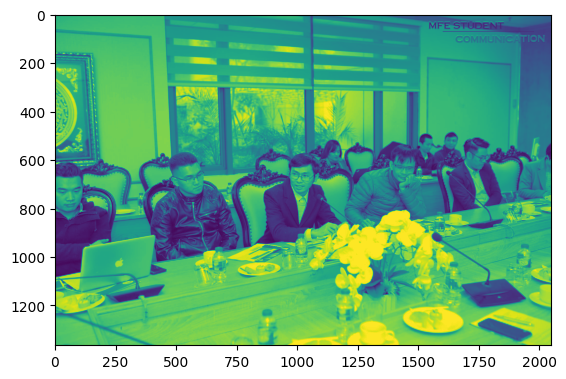

In [3]:
url = str('https://imgur.com/nmGz7Lv.png')
with urllib.request.urlopen(url) as url:
    f = BytesIO(url.read())

X = np.array(Image.open(f))
print('Image shape: %s'%str(X.shape))
# Convert to grey
X = X.dot([0.299, 0.5870, 0.114])
print('Image shape: %s'%str(X.shape))
plt.imshow(X)

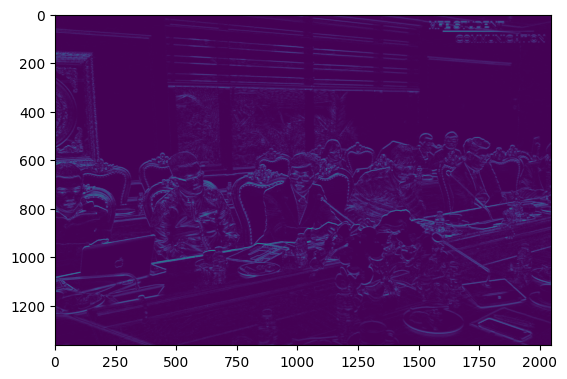

In [4]:
#Tạo bộ lọc ngang F1
F1 = np.array([[-1, -1, -1],
              [0, 0, 0],
              [1, 1, 1]])
#Tính tích chập 2 chiều.
def conv2d(X, F, s = 1, p = 0):
    """
    X: Ma trận đầu vào
    F: Ma trận bộ lọc
    s: Bước trượt
    p: Độ rộng lề thêm vào
    """
    (w1, h1) = X.shape
    f = F.shape[0]
    w2 = int((w1 + 2*p - f)/s) + 1
    h2 = int((h1 + 2*p - f)/s) + 1
    Y = np.zeros((w2, h2))
    X_pad = np.pad(X, pad_width = p, mode = 'constant', constant_values = 0)
    for i in range(w2):
        for j in range(h2):
            idw = i*s
            idh = j*s
            Y[i, j] = np.abs(np.sum(X_pad[idw:(idw+f), idh:(idh+f)]*F))
    return Y

Y1 = conv2d(X, F1, s = 1, p = 0)
plt.imshow(Y1)

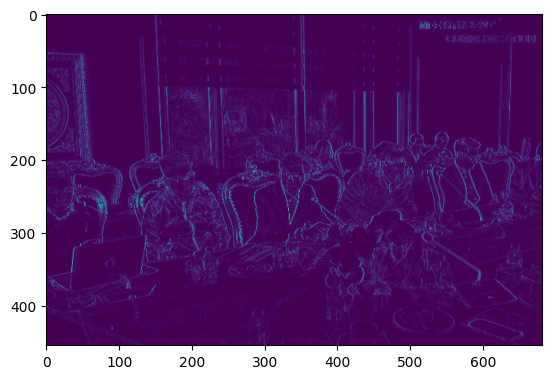

In [5]:
#Tạo bộ lọc dọc F2
F2 = np.array([[1, 0, -1],
             [1, 0, -1],
             [1, 0, -1]])
Y2 = conv2d(X, F2, s = 3, p = 0)
plt.imshow(Y2)

## CNN

1. Các thuật ngữ:
   - Ma trận đầu vào: Ma trận ảnh ban đầu.
   - Ma trận bộ lọc: Ma trận có kích thước nhỏ hơn ma trận đầu vào, dùng để lọc thông tin từ ma trận đầu vào.
   - Đơn vị (Unit): Là giá trị của một điểm nằm trên ma trận khối ở mỗi tầng của mạng CNN.
   - Vùng nhận thức (Receptive Field): Là một vùng ảnh trên khối ma trận đầu vào mà bộ lọc sẽ nhân tích chập để ánh xạ tới một đơn vị trên layer tiếp theo.
   - Vùng địa phương (Local region): Theo một nghĩa nào đó sẽ bao hàm cả vùng nhận thức. Là một vùng ảnh cụ thể nằm trên khối ma trận ở các tầng (layer) của mạng CNN.
   - Bản đồ đặc trưng (Feature Map): Là ma trận đầu ra khi áp dụng phép tích chập giữa bộ lọc với các vùng nhận thức theo phương di chuyển từ trái qua phải và từ trên xuống dưới.
   - Bản đồ kích hoạt (Activation Map): Là output của bản đồ đặc trưng CNN khi áp dụng thêm hàm activation để tạo tính phi tuyến.

2. Kiến thức chung:
    - Thiết kế cơ bản: INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC
    - Trong đó:
        + INPUT: Tầng đầu vào
        + CONV: Tầng tích chập
        + RELU: Tầng kích hoạt. Thông qua hàm kích hoạt (activation function), thường là ReLU hoặc LeakyReLU để kích hoạt phi tuyến
        + POOL: Tầng tổng hợp, thông thường là Max pooling hoặc có thể là Average pooling dùng để giảm chiều của ma trận đầu vào.
        + FC: Tầng kết nối hoàn toàn. Thông thường tầng này nằm ở sau cùng và kết nối với các đơn vị đại diện cho nhóm phân loại.
    - Mạng nơ ron tích chấp có 3 quá trình khác nhau:
        + Convolutional Layer: Áp dụng bộ lọc để tìm ra các đặc trưng của ảnh.
        + Pooling Layer: Giảm kích thước của ảnh.
        + Fully-Connected Layer: Kết nối tất cả các đặc trưng đã tìm được để phân loại.


In [17]:
import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# tf.logging.set_verbosity(tf.logging.INFO)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

def cnn_model_fn(features, labels, mode):
    """Model function for CNN"""
    #Input layer
    input_layer = tf.reshape(features['x'], shape = [-1, 28, 28, 1])
    
    #Convolution layer 1
    conv1 = tf.layers.conv2d(
        inputs = input_layer,
        filters = 32,
        kernel_size = [5, 5],
        padding = 'same',
        activation = tf.nn.relu)
    #Apply formula:N1 = (N+2P-f)/S + 1
    #in which: N is input image size, P is padding size, f is filter size and S is step
    #Output tensor shape: N1 = (28-5)/1+1 = 24 => shape = [-1, 24, 24, 1]
    #But we at parameter we set padding = 'same' in order to keep output shape unchange to input shape 
    #Thus output shape is [-1, 28, 28, 1]
    
    #Max pooling layer 1
    pool1 = tf.layers.max_pooling2d(
        inputs = conv1, 
        pool_size = [2, 2],
        strides = 2)
    #Output tensor shape: N2 = (28-2)/2+1 = 14 => shape = [-1, 14, 14, 1]
    
    #Convolution layer 2
    conv2 = tf.layers.conv2d(
        inputs = pool1,
        filters = 64,
        kernel_size = [5, 5],
        padding = 'same',
        activation = tf.nn.relu)
    #Output tensor shape: N3 = (14-5)/1+1 = 10 => shape = [-1, 10, 10, 1]
    #But padding = 'same' so output shape is [-1, 14, 14, 1]
    
    #Max pooling layer 2
    pool2 = tf.layers.max_pooling2d(
        inputs = conv2,
        pool_size = [2, 2],
        strides = 2)
    #Output tensor shape: N4 = (14-2)/2+1 = 7 => shape = [-1, 7, 7, 1]
    
    #Dense layer
    flat = tf.reshape(pool2, [-1, 7*7*64])
    dense = tf.layers.dense(
        inputs = flat, 
        units = 1024,
        activation = tf.nn.relu)
    
    dropout = tf.layers.dropout(
        inputs = dense,
        rate = 0.4,
        training = mode == tf.estimator.ModeKeys.TRAIN)
    
    #Logits layer
    logits = tf.layers.dense(inputs = dropout, units = 10)
    
    predictions = {
        'classes': tf.argmax(input = logits, axis = 1, name = 'class_tensor'),
        'probabilities': tf.nn.softmax(logits, name = 'softmax_tensor')}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions = predictions)

    loss = tf.losses.sparse_softmax_cross_entropy(labels = labels, logits = logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
        train_op = optimizer.minimize(
            loss = loss, 
            global_step = tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode = mode, loss = loss, train_op = train_op)
    
    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = {
            'accuracy': tf.metrics.accuracy(
            labels = labels, predictions = predictions['classes'])}
        return tf.estimator.EstimatorSpec(
            mode = mode, loss = loss, eval_metric_ops = eval_metric_ops)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 5)
        self.fc1 = nn.Linear(64*4*4, 1024)
        self.fc2 = nn.Linear(1024, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 64*4*4)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

11490434/11490434 [==============================] - 10s 1us/step
Train images shape      : (60000, 28, 28)
Train labels shape      : (60000,)
Test  images shape      : (10000, 28, 28)
Test  labels shape      : (10000,)


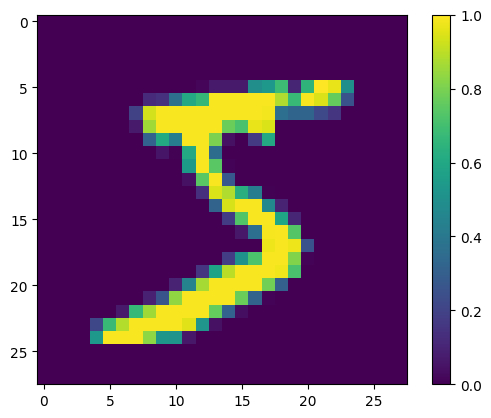

In [14]:
# import sys
# !{sys.executable} -m pip install python-mnist

# from mnist import MNIST
# mndata = MNIST('./Tutorial/data')

# mndata.load_training()
# train_data = np.asarray(mndata.train_images)/255.0
# train_labels = np.array(mndata.train_labels.tolist())

# mndata.load_testing()
# test_data = np.asarray(mndata.test_images)/255.0
# test_labels = np.array(mndata.test_labels.tolist())

# print('Train images shape      : %s'%str(train_data.shape))
# print('Train labels shape shape: %s'%str(train_labels.shape))
# print('Test  images shape      : %s'%str(test_data.shape))
# print('Test  labels shape shape: %s'%str(test_labels.shape))

import tensorflow as tf
import matplotlib.pyplot as plt

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Print the shapes
print('Train images shape      :', train_images.shape)
print('Train labels shape      :', train_labels.shape)
print('Test  images shape      :', test_images.shape)
print('Test  labels shape      :', test_labels.shape)

# Visualize the first image from the training dataset
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [25]:
model = CNN()
print(model)


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)


In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()

# Convert the numpy arrays to torch tensors
train_images = torch.from_numpy(train_images).float()
train_labels = torch.from_numpy(train_labels).long()

# Create a torch dataset
train_data = torch.utils.data.TensorDataset(train_images, train_labels)

# Create a data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle = True)

# Train the model
for epoch in range(2):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 1, 28, 28)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, 2, i+1, len(train_data)//32, loss.item()))

Epoch [1/2], Step [100/1875], Loss: 0.2972
Epoch [1/2], Step [200/1875], Loss: 0.1936
Epoch [1/2], Step [300/1875], Loss: 0.2057
Epoch [1/2], Step [400/1875], Loss: 0.1146
Epoch [1/2], Step [500/1875], Loss: 0.0592
Epoch [1/2], Step [600/1875], Loss: 0.0144
Epoch [1/2], Step [700/1875], Loss: 0.4385
Epoch [1/2], Step [800/1875], Loss: 0.0399
Epoch [1/2], Step [900/1875], Loss: 0.0163
Epoch [1/2], Step [1000/1875], Loss: 0.0302
Epoch [1/2], Step [1100/1875], Loss: 0.1277
Epoch [1/2], Step [1200/1875], Loss: 0.0492
Epoch [1/2], Step [1300/1875], Loss: 0.0480
Epoch [1/2], Step [1400/1875], Loss: 0.0036
Epoch [1/2], Step [1500/1875], Loss: 0.0131
Epoch [1/2], Step [1600/1875], Loss: 0.0667
Epoch [1/2], Step [1700/1875], Loss: 0.0068
Epoch [1/2], Step [1800/1875], Loss: 0.0078
Epoch [2/2], Step [100/1875], Loss: 0.0115
Epoch [2/2], Step [200/1875], Loss: 0.0097
Epoch [2/2], Step [300/1875], Loss: 0.0506
Epoch [2/2], Step [400/1875], Loss: 0.0246
Epoch [2/2], Step [500/1875], Loss: 0.0018
Ep

In [27]:
# Convert the test images to torch tensor
test_images = torch.from_numpy(test_images).float()
test_labels = torch.from_numpy(test_labels).long()

# Create a torch dataset
test_data = torch.utils.data.TensorDataset(test_images, test_labels)

# Create a data loader
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 32, shuffle = False)

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 1, 28, 28)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))

Test Accuracy of the model on the 10000 test images: 98.7700 %


In [19]:
mnist_classifier = tf.estimator.Estimator(
    model_fn = cnn_model_fn, 
    model_dir = './tmp/conv2_checkpoints' #temporary file to save model
)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './tmp/conv2_checkpoints', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [21]:
train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    x = {'x': train_images},
    y = train_labels,
    batch_size = 100,
    num_epochs = None,
    shuffle = True)

In [22]:
# mnist_classifier.train(
#     input_fn = train_input_fn,
#     steps = 10000
# #     hooks = [logging_hook]
# )

#Validation on test
# eval_input_fn = tf.estimator.inputs.numpy_input_fn(
#       x = {"x": test_data},
#       y = test_labels,
#       num_epochs = 1,
#       shuffle = False)

# eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
# print(eval_results)

INFO:tensorflow:Calling model_fn.


AttributeError: module 'tensorflow' has no attribute 'layers'